# Quiver plot for vertical profiles 

* This notebook contains similar code to the 2D correlation plots 
* We are just changing one of our dimensions to cover a vertical profile rather than longitudinal 
* We have over a longitudinal area to make this happen
* If this isn't clear going through this notebook will reveal all 
* This is to predominantly analyse winds, we need u, v and w winds 

In [1]:
import iris
import iris.plot as iplt
import iris.quickplot as qplt
import iris.coord_categorisation

import numpy as np 
import numpy.ma as ma
import pandas as pd 
import matplotlib.pyplot as plt

from scipy import signal
import scipy.stats as sp
from sklearn.linear_model import LinearRegression

import cartopy

import pandas as pd
import matplotlib
import warnings; warnings.simplefilter("ignore")

* First let's load in the data we are using 

In [2]:
directory = f'/data/users/ncreaser/ERA5_download/data/Concatenated/Meridional/'

In [3]:
w_levels = iris.load_cube(f'{directory}era5_monthly_w_wind_all_levels_1978_2019.nc')
v_levels = iris.load_cube(f'{directory}era5_monthly_v_wind_all_levels_1978_2019.nc')
u_levels = iris.load_cube(f'{directory}era5_monthly_u_wind_all_levels_1978_2019.nc')

In [4]:
w_levels

Lagrangian Tendency Of Air Pressure (Pa s**-1),time,pressure_level,latitude,longitude
Shape,504,37,381,101
Dimension coordinates,,,,
time,x,-,-,-
pressure_level,-,x,-,-
latitude,-,-,x,-
longitude,-,-,-,x
Attributes,,,,Conventions 'CF-1.7'


* Can see we now have an extra coordinate, the 'pressure_level'

In [5]:
def add_coords(cube, seasons = ('djf','mam','jja','son')):
    iris.coord_categorisation.add_month(cube, 'time', name='month')
    iris.coord_categorisation.add_year(cube, 'time', name='year')
    iris.coord_categorisation.add_season(cube, 'time', name='season', seasons=seasons)

In [6]:
add_coords(w_levels)
add_coords(v_levels)
add_coords(u_levels)

* you may notice our data starts in 1978 now rather than 1979
* We can select a period by using a iris constraint 

In [7]:
period_constraint = iris.Constraint(coord_values={'year':lambda cell: 1979 <= cell <= 2019})
w_levels = w_levels.extract(period_constraint)
v_levels = v_levels.extract(period_constraint)
u_levels = u_levels.extract(period_constraint)

In [8]:
def extract_relevent_season(cube, season_name):
    constraint = iris.Constraint(season = season_name)
    return cube.extract(constraint)

In [9]:
season_w_levels = extract_relevent_season(w_levels, 'jja')
season_v_levels = extract_relevent_season(v_levels, 'jja')
season_u_levels = extract_relevent_season(u_levels, 'jja')

In [10]:
season_w_levels = season_w_levels.aggregated_by(['year'], iris.analysis.MEAN)
season_v_levels = season_v_levels.aggregated_by(['year'], iris.analysis.MEAN)
season_u_levels = season_u_levels.aggregated_by(['year'], iris.analysis.MEAN)

* This next part is where we deviate from our previous method 
* We extract data from 120 - 135 degrees east
    * This is the longitudinal extent of our farming region
* This will then be avaegred so we once again have a cube with 3 dimensions 
* We can do this in iris by creating a constraint on the longitude

In [11]:
lon_constraint = iris.Constraint(longitude=lambda cell: 120 < cell < 135)

In [12]:
season_w_levels_cut = season_w_levels.extract(lon_constraint)
season_v_levels_cut = season_v_levels.extract(lon_constraint)
season_u_levels_cut = season_u_levels.extract(lon_constraint)

* Now we have extracted our region we can collapase the longitude and take the mean 

In [13]:
season_w_levels_avg_lon = season_w_levels_cut.collapsed(['longitude'], iris.analysis.MEAN)
season_v_levels_avg_lon = season_v_levels_cut.collapsed(['longitude'], iris.analysis.MEAN)
season_u_levels_avg_lon = season_u_levels_cut.collapsed(['longitude'], iris.analysis.MEAN)

In [14]:
season_w_levels_avg_lon

Lagrangian Tendency Of Air Pressure (Pa s**-1),time,pressure_level,latitude
Shape,41,37,381
Dimension coordinates,,,
time,x,-,-
pressure_level,-,x,-
latitude,-,-,x
Auxiliary coordinates,,,
month,x,-,-
season,x,-,-
year,x,-,-
Scalar coordinates,,,"longitude 127.5 degrees, bound=(120.25, 134.75) degrees"


* Now we're free to use our existing code for correlations, since we are still dealing with 3 dimensions
* Lets not forget to detrend and normalise!

In [15]:
def detrend_normalise_cube(cube):
    detrend_data = signal.detrend(cube.data.reshape(cube.shape[0], -1), axis=0,overwrite_data=True) # detrend the data
    normalised = (detrend_data - np.mean(detrend_data, axis=0))/(np.std(detrend_data, axis=0))
    normalised = np.reshape(normalised,cube.shape)
    cube.data = normalised
    return cube

In [16]:
season_w_levels_avg_lon = detrend_normalise_cube(season_w_levels_avg_lon)
season_v_levels_avg_lon = detrend_normalise_cube(season_v_levels_avg_lon)
season_u_levels_avg_lon = detrend_normalise_cube(season_u_levels_avg_lon)

* Let's load in our climate index

In [17]:
cli_index = 'iod'
cli_index_df = pd.read_csv(f'/data/users/ncreaser/CSSP_china/data/Indices/{cli_index}_monthly_longer.csv',  index_col='Year').loc[1979:2019]
cli_index_df.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1979,0.382,-0.078,0.066,-0.132,-0.364,0.222,-0.218,-0.114,-0.174,-0.154,-0.128,-0.032
1980,-0.093,-0.120,-0.317,-0.020,0.014,-0.268,-0.564,-0.710,-0.639,-0.498,-0.294,-0.413
1981,-0.136,0.056,0.127,0.168,0.062,-0.126,-0.463,-0.516,-0.651,-0.447,-0.204,0.050
1982,0.209,0.246,0.154,0.194,0.302,0.369,0.362,0.369,0.548,0.783,0.407,-0.093
1983,-0.416,-0.507,-0.652,-0.481,0.021,0.484,0.621,0.457,0.037,-0.128,-0.220,-0.031


In [18]:
cli_index_month = cli_index_df.loc[:,'Mar']
cli_index_month = signal.detrend(cli_index_month.to_numpy())

In [19]:
cli_index_month = (cli_index_month - np.mean(cli_index_month)) / np.std(cli_index_month)

* Lets go to making some correlations 

In [20]:
def return_regression_cube(cube, type_of_cube):
    reg_cube = cube[0].copy()
    reg_cube.long_name = type_of_cube
    reg_cube.standard_name = None
    reg_cube.units = ''
    return reg_cube

def return_pearson_cubes(cube):
    ''' Takes a cube with a weather variable and renames etc '''
    corr_cube = cube[0].copy()
    corr_cube.long_name = 'Pearson Correlation Coefficient'
    corr_cube.standard_name = None
    corr_cube.units = ''
    
    corr_pvals_cube = cube[0].copy()
    corr_pvals_cube.long_name = 'p-values'
    corr_pvals_cube.standard_name = None
    corr_pvals_cube.units = ''

    return corr_cube, corr_pvals_cube

* At this point it's worth explaining what each bit of data is doing 
* The U wind isn't going to plotted as wind, but rather as shaded correlation with the climate index
* W and V wind is going to plotted as wind (regression coefficent) of the regression with the climate index 
* This will result in our x axis = latitude and y axis = vertical levels (pressure)
* The shading then signals u wind correlation and this is gives information in the direction coming our/into screen, making out plot 3D almost
* Using our same function from the 2d correlations notebook we can do this

In [21]:
def run_correlations(normalised_cube, climate_index, corr_cube, corr_pvals_cube, u_cube = None, 
                     v_cube = None, y_coord = 'latitude', x_coord = 'longitude'):
    corr_cube_copy = corr_cube.copy()
    corr_pvals_cube_copy = corr_pvals_cube.copy()
    u_reg_cube = return_regression_cube(u_cube, 'Regression u cube')
    v_reg_cube = return_regression_cube(v_cube, 'Regression v cube')
    
    # Run over latitude and longitude (or alternative coordinates), and populate the cubes with correlation and p-value
    for i in range(len(normalised_cube.coord(y_coord).points)):
        for j in range(len(normalised_cube.coord(x_coord).points)):
            cube_by_gridpoint = normalised_cube.data[:, i, j]
            corrcoefs, p_vals = sp.pearsonr(climate_index, cube_by_gridpoint)
            corr_cube_copy.data[i,j] = corrcoefs
            corr_pvals_cube_copy.data[i,j] = p_vals
            
            # do regression 
            if u_cube is not None and v_cube is not None:
                u_cube_by_gridpoint = u_cube.data[:,i,j]
                v_cube_by_gridpoint = v_cube.data[:,i,j]

                u_reg = LinearRegression().fit(climate_index.reshape(-1,1), u_cube_by_gridpoint.reshape(-1,1))
                u_reg_cube.data[i,j] = u_reg.coef_[0][0]
                
                v_reg = LinearRegression().fit(climate_index.reshape(-1,1), v_cube_by_gridpoint.reshape(-1,1))
                v_reg_cube.data[i,j] = v_reg.coef_[0][0]
            
    return corr_cube_copy, corr_pvals_cube_copy, u_reg_cube, v_reg_cube

In [22]:
corr_cube, pvals_cube = return_pearson_cubes(season_u_levels_avg_lon)
    
pearson_cube , p_values, w_reg_season, v_reg_season = run_correlations(season_u_levels_avg_lon,
                                                                       cli_index_month, 
                                                                       corr_cube,
                                                                       pvals_cube,
                                                                       u_cube = season_w_levels_avg_lon, 
                                                                       v_cube = season_v_levels_avg_lon,
                                                                       y_coord = 'pressure_level', 
                                                                       x_coord = 'latitude')

* We can now produce our plot using the same methods as before 

Text(0, 0.5, 'Pressure ($hPa$)')

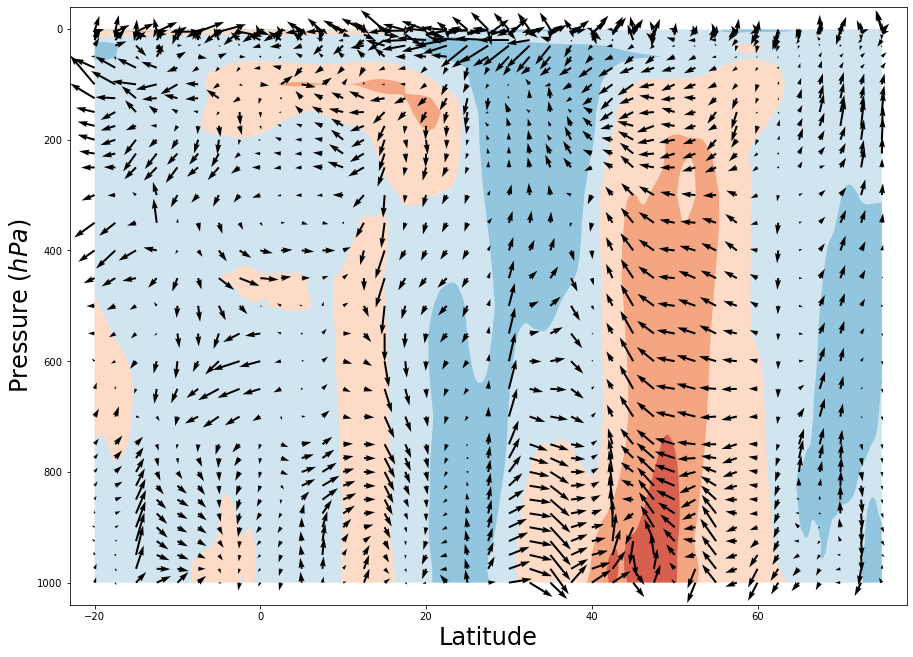

In [27]:
fig, ax= plt.subplots(figsize = (15,11))
contour_levels = np.arange(-1, 1.1, 0.2)
cmap = 'brewer_RdBu_11'
conf = iplt.contourf(pearson_cube, levels = contour_levels , cmap=cmap, axes = ax)
ax.set_xlim(left = -23, right = 78)
ax.set_ylim(bottom = 1040, top = -40)
Q = iplt.quiver(v_reg_season[::1,::10], w_reg_season[::1,::10])

plt.xlabel('Latitude',fontsize = 24)
plt.ylabel('Pressure ($hPa$)',fontsize = 24)